# This is a tutorial of using spaVAE for the 10X mouse anterior brain datasets, which contain two batches

This tutorial was implemented on Macbook Pro M2.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE_Batch import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import h5py
import scanpy as sc
from preprocess import normalize

Setup parameters. spaVAE_Batch stands for spaVAE model for batches of data. There are more parameters for spaVAE batched version:

--shared_dispersion: whether using shared dispersion for the NB loss of different batches, default is false, it means each batch has its own dispersion parameter

--allow_batch_kernel_scale: whether allowing each batch has its own kernel scale, default is true.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'anterior_section1.h5_anterior_section2.h5_union_ant.h5'
        self.select_genes = 0
        self.batch_size = "auto"
        self.maxiter = 5000
        self.train_size = 0.95
        self.patience = 200
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.GP_dim = 2
        self.Normal_dim = 8
        self.decoder_layers = [128]
        self.init_beta = 10
        self.min_beta = 4
        self.max_beta = 25
        self.KL_loss = 0.025
        self.num_samples = 1
        self.shared_dispersion = False
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 8
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.allow_batch_kernel_scale = True
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.num_denoise_samples = 10000
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
batch = np.array(data_mat['batch']).astype('float64')
data_mat.close()

if args.batch_size == "auto":
    if x.shape[0] <= 1024:
        args.batch_size = 128
    elif x.shape[0] <= 2048:
        args.batch_size = 256
    else:
        args.batch_size = 512
else:
    args.batch_size = int(args.batch_size)
    
print(args)

n_batch = batch.shape[1]

# scale locations per batch
loc_scaled = np.zeros(loc.shape, dtype=np.float64)
for i in range(n_batch):
    scaler = MinMaxScaler()
    b_loc = loc[batch[:,i]==1, :]
    b_loc = scaler.fit_transform(b_loc) * args.loc_range
    loc_scaled[batch[:,i]==1, :] = b_loc
loc = loc_scaled

loc = np.concatenate((loc, batch), axis=1)

print(x.shape)
print(loc.shape)
print(batch.shape)

# build inducing point matrix with batch index
eps = 1e-5
initial_inducing_points_0_ = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
initial_inducing_points_0 = np.tile(initial_inducing_points_0_, (n_batch, 1))
initial_inducing_points_1 = []
for i in range(n_batch):
    initial_inducing_points_1_ = np.zeros((initial_inducing_points_0_.shape[0], n_batch))
    initial_inducing_points_1_[:, i] = 1
    initial_inducing_points_1.append(initial_inducing_points_1_)
initial_inducing_points_1 = np.concatenate(initial_inducing_points_1, axis=0)
initial_inducing_points = np.concatenate((initial_inducing_points_0, initial_inducing_points_1), axis=1)
print(initial_inducing_points.shape)

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, GP_dim=args.GP_dim, Normal_dim=args.Normal_dim, n_batch=n_batch, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD, shared_dispersion=args.shared_dispersion,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, allow_batch_kernel_scale=args.allow_batch_kernel_scale,
    N_train=adata.n_obs, KL_loss=args.KL_loss, init_beta=args.init_beta, min_beta=args.min_beta, max_beta=args.max_beta, dtype=torch.float64, device=args.device)

print(str(model))

(5520, 2491)
(5520, 4)
(5520, 2)
(162, 4)
SPAVAE(
  (svgp): SVGP(
    (kernel): BatchedCauchyKernel()
    (sample_kernel): SampleKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=2493, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=10, bias=True)
    (enc_var): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (dec_mean): Sequential(
    (0): Linear(in_features=128, out_features=2491, bias=True)
    (1):

Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors, batch=batch,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            train_size=args.train_size, maxiter=args.maxiter, patience=args.patience, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, B=batch, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")

denoised_counts = model.batching_denoise_counts(X=loc, Y=adata.X, B=batch, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.denoised_counts_file, denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:5952.10607061, NB loss:5928.52465943, GP KLD loss:0.05624662, Gaussian KLD loss:2.25256593, noise regularization:0.000000
Current beta 10.499203543178673
Current kernel scale tensor([20.0035, 19.9998])
Training epoch 1, validating ELBO:5592.54399940
Training epoch 2, ELBO:5446.34376055, NB loss:5415.43114517, GP KLD loss:0.10974844, Gaussian KLD loss:2.76300219, noise regularization:0.000000
Current beta 11.069260951634808
Current kernel scale tensor([19.9994, 19.9919])
Training epoch 2, validating ELBO:5160.46043447
Training epoch 3, ELBO:5060.94132133, NB loss:5025.58993010, GP KLD loss:0.10838982, Gaussian KLD loss:2.99782702, noise regularization:0.000000
Current beta 11.788169661788043
Current kernel scale tensor([19.9985, 19.9863])
Training epoch 3, validating ELBO:4820.74434253
Training epoch 4, ELBO:4745.53263528, NB loss:4713.41315231, GP KLD loss:0.10685526, Gaussian KLD loss:2.55116624, noise regularization:0.000000
Current beta 12.43643918833

Louvain clustering of latent embedding.

In [5]:
adata_latent = sc.AnnData(final_latent)
sc.pp.neighbors(adata_latent, n_neighbors=20, use_rep="X")
res = 0.2
while True:
    print("current resolution", res)
    sc.tl.louvain(adata_latent, resolution=res)
    y_pred = np.asarray(adata_latent.obs['louvain'], dtype=int)
    if np.unique(y_pred).shape[0] >= 11:
        break
    res += 0.001

np.savetxt("louvain_clustering_labels.txt", y_pred, delimiter=",", fmt="%i")


/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

current resolution 0.2
current resolution 0.201
current resolution 0.202
current resolution 0.203
current resolution 0.20400000000000001
current resolution 0.20500000000000002
current resolution 0.20600000000000002
current resolution 0.20700000000000002
current resolution 0.20800000000000002
current resolution 0.20900000000000002
current resolution 0.21000000000000002
current resolution 0.21100000000000002
current resolution 0.21200000000000002
current resolution 0.21300000000000002
current resolution 0.21400000000000002
current resolution 0.21500000000000002
current resolution 0.21600000000000003
current resolution 0.21700000000000003
current resolution 0.21800000000000003
current resolution 0.21900000000000003
current resolution 0.22000000000000003
current resolution 0.22100000000000003
current resolution 0.22200000000000003
current resolution 0.22300000000000003
current resolution 0.22400000000000003
current resolution 0.22500000000000003
current resolution 0.22600000000000003
curre

Conduct differential expression analysis.

In [6]:
data_mat = h5py.File(args.data_file, 'r')
gene = np.array(data_mat['gene']).astype('U26')
data_mat.close()

y = np.loadtxt("louvain_clustering_labels.txt").astype("int")

# raw counts
raw_adata = sc.AnnData(x, dtype="float64")

raw_adata = normalize(raw_adata,
                  size_factors=True,
                  normalize_input=False,
                  logtrans_input=False)

for i in np.unique(y):
    layer_idx = np.where(np.array(y==i, dtype=bool))[0]
    not_layer_idx = np.where(np.array(y!=i, dtype=bool))[0]

    print("cluster:", i)

    res_dat = model.differential_expression(group1_idx=layer_idx, group2_idx=not_layer_idx, num_denoise_samples=10000,
                    batch_size=args.batch_size, pos=loc, ncounts=adata.X, batch=batch, gene_name=gene, raw_counts=raw_adata.X)

    res_dat.to_csv("Mouse_anterior_cluster_"+str(i)+"_vs_others_LFC.txt")

cluster: 0
Estimated pseudocounts 0.05
LFC delta: 0.4133095228953474
cluster: 1
Estimated pseudocounts 0.05
LFC delta: 0.4217525573385129
cluster: 2
Estimated pseudocounts 0.05
LFC delta: 0.3
cluster: 3
Estimated pseudocounts 0.05
LFC delta: 0.3229191455371202
cluster: 4
Estimated pseudocounts 0.05
LFC delta: 0.3
cluster: 5
Estimated pseudocounts 0.05
LFC delta: 0.4320779525945805
cluster: 6
Estimated pseudocounts 0.05
LFC delta: 0.6157401832710608
cluster: 7
Estimated pseudocounts 0.05
LFC delta: 0.4222323844949226
cluster: 8
Estimated pseudocounts 0.05
LFC delta: 0.47907432595940885
cluster: 9
Estimated pseudocounts 0.05
LFC delta: 0.3
cluster: 10
Estimated pseudocounts 0.3262328854212246
LFC delta: 0.3027736333962338


## Plotting results in R and ggplot2.

Plot spaVAE latent representations, Louvain clustering labels and Alluvial plot of cluster proportions. Latent representations are not exactly same as the plot in the manuscript, due to different random initialisations.

Warning message:
“Duplicated `override.aes` is ignored.”


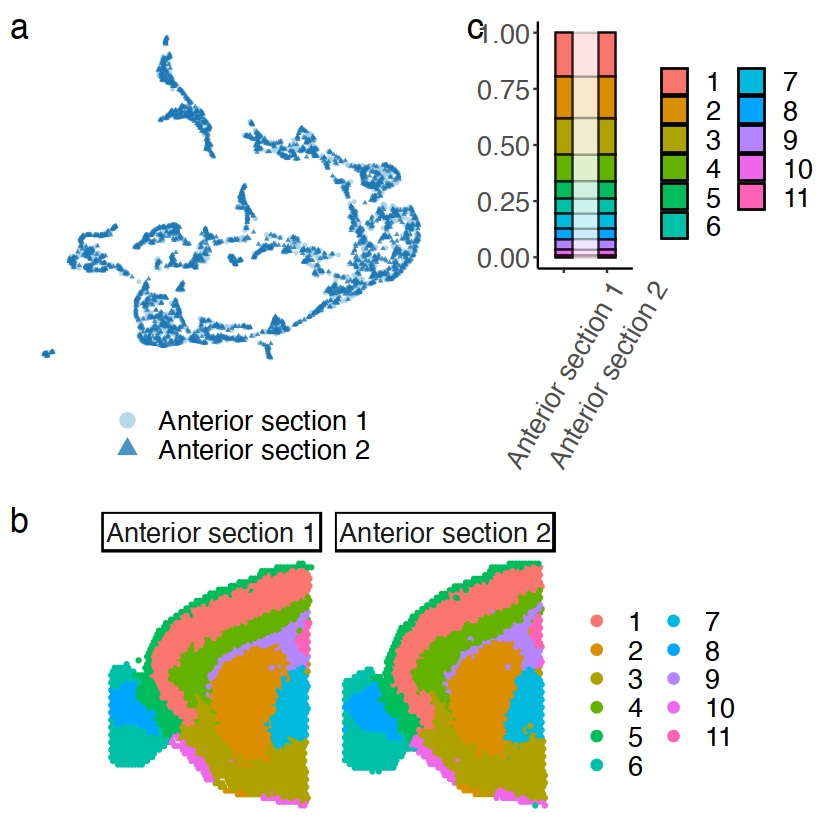

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(ggalluvial)
library(cowplot)
library(RColorBrewer)
library(pheatmap)
library(umap)

batch <- h5read("anterior_section1.h5_anterior_section2.h5_union_ant.h5", "batch")
batch2 <- apply(batch, 2, function(z) which.max(z))
batch3 <- batch2
batch3[batch2==1] <- "Anterior section 1"
batch3[batch2==2] <- "Anterior section 2"

latent <- read.table("final_latent.txt", sep=",")

pos <- t(h5read("anterior_section1.h5_anterior_section2.h5_union_ant.h5", "pos"))
label <- as.numeric(readLines("louvain_clustering_labels.txt"))+1

latent <- read.table("final_latent.txt", sep=",")
umap.res <- umap(latent, method="naive")

### plot embedding
embed.dat <- data.frame(umap.res$layout, batch=batch3)

p1 <- ggplot(embed.dat, aes(x=X1, y=X2, color=batch, shape=batch)) + 
  geom_point(size=0.8, alpha=0.8) + theme_classic() +
  scale_color_brewer(palette = "Paired") +
  guides(colour = guide_legend(override.aes = list(size=4), nrow=2), shape=guide_legend(override.aes = list(size=4), nrow=2)) +
  theme(axis.title=element_blank(), axis.line=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(),
        legend.position="bottom", legend.title=element_blank(), text = element_text(size=20))

### plot clustering results
cluster.dat <- data.frame(pos, label=label, batch=batch3)

cluster.dat$label <- factor(cluster.dat$label, levels=1:max(label))
cluster.dat$batch <- factor(cluster.dat$batch, levels=c("Anterior section 1", "Anterior section 2"))

p2 <- ggplot(cluster.dat, aes(x=X1, y=X2, color=label)) + 
  facet_wrap(~batch, scales="free") + geom_point(size=0.7) + scale_x_reverse() + coord_flip() +
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2.5), ncol=2)) +
  theme(axis.title=element_blank(), axis.line=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), legend.position = "right", text = element_text(size=20))


### alluvial plot
celltype.dat <- data.frame(celltype=label, batch=batch3)

ante.sec1.celltype.dat <- celltype.dat[celltype.dat$batch=="Anterior section 1",]
ante.sec1.cell_types_prop <- data.frame(prop=table(ante.sec1.celltype.dat$celltype)/length(ante.sec1.celltype.dat$celltype))
ante.sec1.cell_types_prop$Label <- paste(round(ante.sec1.cell_types_prop$prop.Freq * 100, 1), "%", sep="")
ante.sec1.cell_types_prop$prop.Var1 <- factor(ante.sec1.cell_types_prop$prop.Var1, levels=1:max(label))
ante.sec1.cell_types_prop$batch <- "Anterior section 1"


ante.sec2.celltype.dat <- celltype.dat[celltype.dat$batch=="Anterior section 1",]
ante.sec2.cell_types_prop <- data.frame(prop=table(ante.sec2.celltype.dat$celltype)/length(ante.sec2.celltype.dat$celltype))
ante.sec2.cell_types_prop$Label <- paste(round(ante.sec2.cell_types_prop$prop.Freq * 100, 1), "%", sep="")
ante.sec2.cell_types_prop$prop.Var1 <- factor(ante.sec2.cell_types_prop$prop.Var1, levels=1:max(label))
ante.sec2.cell_types_prop$batch <- "Anterior section 2"

cell_types_prop <- rbind(ante.sec1.cell_types_prop, ante.sec2.cell_types_prop)
cell_types_prop$batch <- factor(cell_types_prop$batch, levels=c("Anterior section 1", "Anterior section 2"))

p3 <- ggplot(cell_types_prop, aes(x = batch, y = prop.Freq, fill = prop.Var1, stratum = prop.Var1, alluvium = prop.Var1)) +
  geom_col(width=0.4, color="black") + geom_alluvium(width=0.4, alpha=0.2, color="black") +
  ylab("Fraction") + guides(fill = guide_legend(ncol=2)) + theme_classic() + 
  theme(axis.text.x = element_text(angle = 60, vjust = 0.5, hjust=0.5), axis.title=element_blank(), 
        legend.title = element_blank(), text = element_text(size=20))

plot_grid(plot_grid(p1, p3, align="none", nrow=1, scale=0.95, labels=c("a", "c"), rel_widths=c(1.2, 1), label_size=20),
          plot_grid(NULL,p2,NULL, nrow=1, rel_widths=c(0.1, 1, 0.1)), 
          nrow=2, scale=c(1, 0.95), labels=c("", "b"), rel_heights=c(1, 0.7), label_size=20)


Plot top differential expressed genes by heatmap.

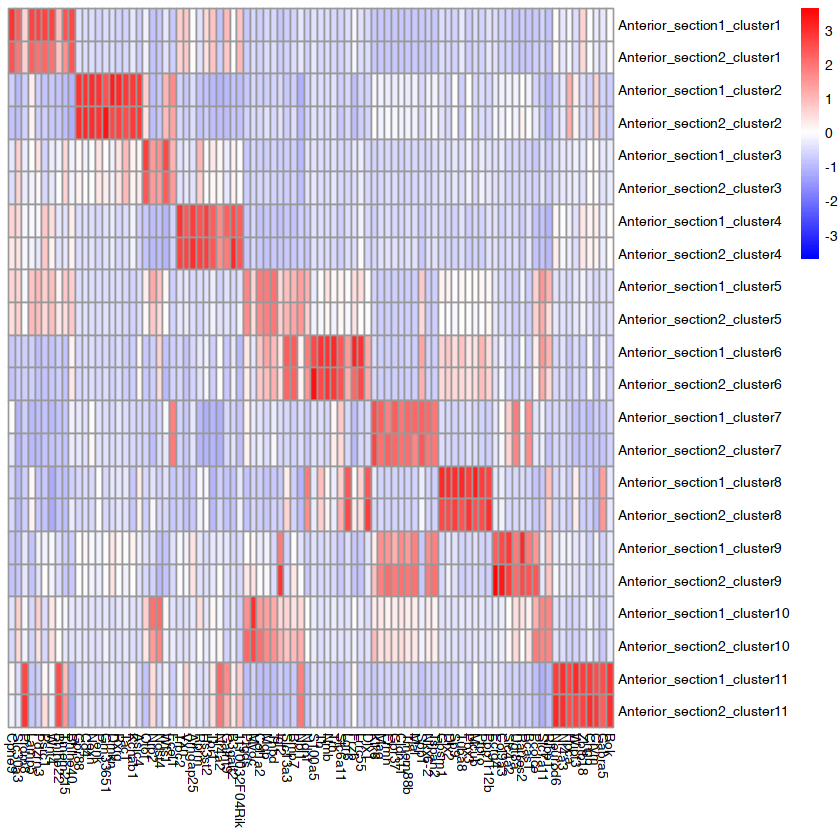

In [2]:
### top DE gene plot
de.res = list()
top.genes <- c()
cluster <- c()
for(i in 1:11) {
  res <- read.table(paste("Mouse_anterior_cluster_",i-1,"_vs_others_LFC.txt",sep=""), sep=",", header=T, row.names = 1)
  res <- res[order(res$LFC, decreasing=T),]
  de.res[[i]] <- res
  res <- res[res$LFC > 1 & res$bayes_factor > log(10), ]
  
  if(nrow(res)==0) next
  num <- min(nrow(res), 10)
  
  top.g <- rownames(res[1:num, ])
  
  if("denoised_mean1_batch0" %in% colnames(res) & "denoised_mean1_batch1" %in% colnames(res)) {
    cluster <- c(cluster, i)
    top.genes <- c(top.genes, top.g)
  }
}

top.genes2 <- unique(top.genes)

de.res.top1 <- sapply(de.res[cluster], function(z) {z[top.genes2, "denoised_mean1_batch0"]})
rownames(de.res.top1) <- top.genes2
colnames(de.res.top1) <- paste("Anterior_section1_cluster", cluster, sep="")

de.res.top2 <- sapply(de.res[cluster], function(z) {z[top.genes2, "denoised_mean1_batch1"]})
rownames(de.res.top2) <- top.genes2
colnames(de.res.top2) <- paste("Anterior_section2_cluster", cluster, sep="")

de.res.top <- cbind(de.res.top1, de.res.top2)
de.res.top <- de.res.top[, paste("Anterior_section", rep(c(1,2), times=length(cluster)), "_cluster", rep(cluster, each=2), sep="")]

de.res.top <- t(scale(t(de.res.top)))
data.scale <- max(abs(max(de.res.top)), abs(min(de.res.top)))

pheatmap(t(de.res.top), cluster_rows = F, cluster_cols = F,
        breaks=seq(from=-data.scale,to=data.scale,len=100),
        color=colorRampPalette(c("blue", "white", "red"))(100), fontsize=8)
